In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import tensorflow as tf  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix  
import glob  
import cv2  
import matplotlib.image as mpimg 

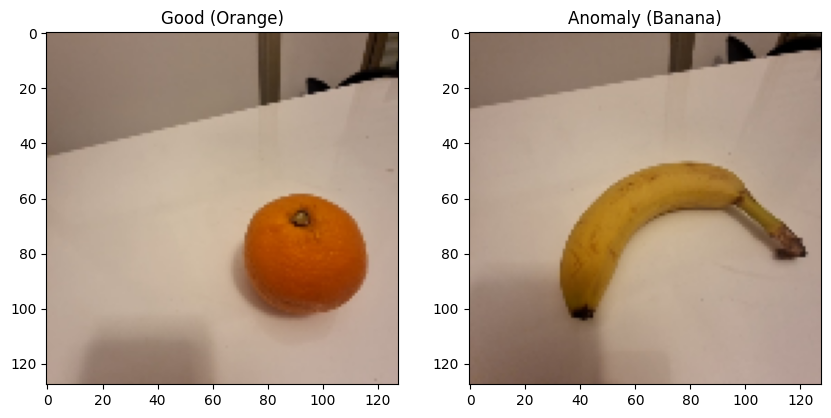

In [2]:
img_size=128
# Define the autoencoder architecture  
latent_dim = 64  
# Function to load images from a directory, resize them, and assign labels  
def load_images_and_labels(image_paths, label):  
    images = []  
    for path in image_paths:  
        image = mpimg.imread(path)  
        image = cv2.resize(image, (img_size,img_size))  # Resize the images  
        # If the image is RGBA (4 channels), convert it to RGB (3 channels)  
        if image.shape[2] == 4:  
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  
        images.append(image)  
    images = np.array(images)  
    labels = np.full(len(images), label)  
    return images, labels  
  
# Load orange and banana images  
orange_paths = glob.glob("dataset/oranges/*.jpg")  
banana_paths = glob.glob("dataset/bananas/*.jpg")  
  
oranges, orange_labels = load_images_and_labels(orange_paths, 0)  # Good  
bananas, banana_labels = load_images_and_labels(banana_paths, 1)  # Anomaly  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].imshow(oranges[0])  # Display the first orange image  
axs[0].set_title("Good (Orange)")  
axs[1].imshow(bananas[0])  # Display the first banana image  
axs[1].set_title("Anomaly (Banana)")  
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
  
# Create an instance of ImageDataGenerator with various augmentations  
data_gen = ImageDataGenerator(  
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)  
)

def augment_images(images, data_gen, num_augmented_imgs_per_original=20):  
    augmented_images = []  
    for img in images:  
        img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)  
        num_augmented_imgs = 0  
        for _ in data_gen.flow(img, batch_size=1):  
            augmented_images.append(_.reshape(img_size, img_size, _.shape[3]))  
            num_augmented_imgs += 1  
            if num_augmented_imgs >= num_augmented_imgs_per_original:  # Stop after generating enough images  
                break  
    return np.array(augmented_images)


# Augment the images for both oranges and bananas  
augmented_oranges = augment_images(oranges, data_gen, num_augmented_imgs_per_original=20)  
augmented_bananas = augment_images(bananas, data_gen, num_augmented_imgs_per_original=20)  
  
# Merge the augmented images with the original ones  
oranges_c = np.concatenate((oranges, augmented_oranges), axis=0).astype(int)  
bananas_c = np.concatenate((bananas, augmented_bananas), axis=0).astype(int)  
  
# Ensure that the labels are updated to match the augmented dataset size  
orange_labels = np.full(len(oranges_c), 0)  # Update for the increased number of orange images  
banana_labels = np.full(len(bananas_c), 1)  # Update for the increased number of banana images  
  
print("Total number of orange images (after augmentation):", len(oranges_c))  
print("Total number of banana images (after augmentation):", len(bananas_c))  

Total number of orange images (after augmentation): 1029
Total number of banana images (after augmentation): 1029


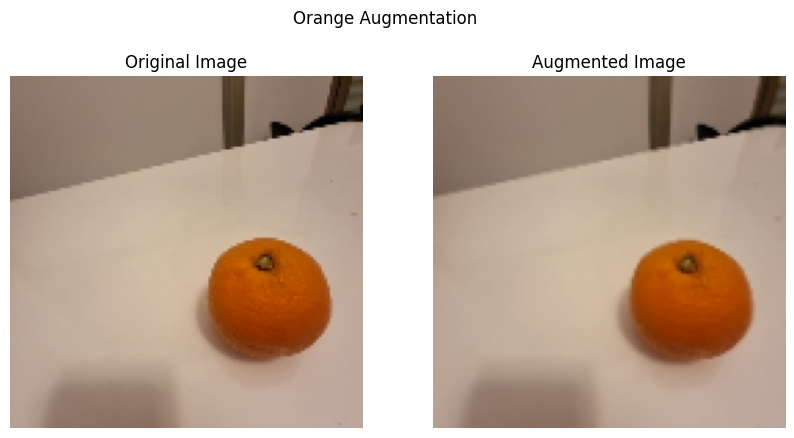

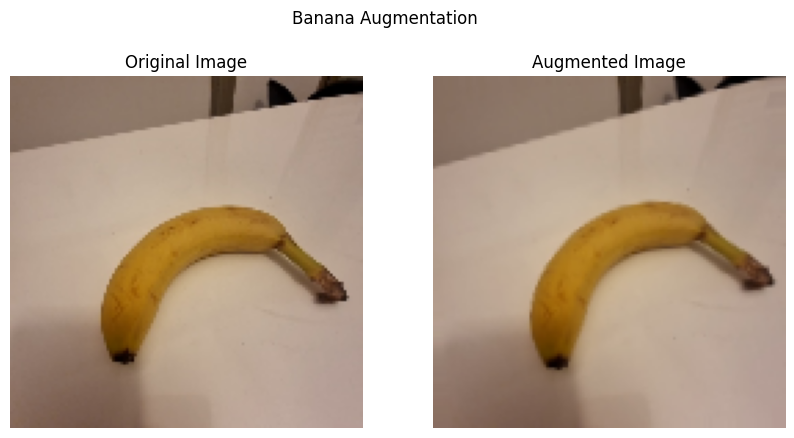

In [4]:
def augment_and_display_image(image, title):  
    image = image.reshape((1,) + image.shape)  # Reshape image to (1, height, width, channels) for the data generator  
    iterator = data_gen.flow(image, batch_size=1)  
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
    axs[0].imshow(image[0])  
    axs[0].set_title('Original Image')  
    augmented_image = next(iterator)[0].astype('uint8')  # Generate augmented image and convert type  
      
    axs[1].imshow(augmented_image)  
    axs[1].set_title('Augmented Image')  
  
    for ax in axs:  
        ax.axis('off')  
    plt.suptitle(title)  
    plt.show()
    
# Display augmented versions of an orange and a banana image  
augment_and_display_image(oranges_c[0], "Orange Augmentation")  
augment_and_display_image(bananas_c[0], "Banana Augmentation")  

In [5]:
# Combine and split the data  
x_data = np.concatenate((oranges_c, bananas_c))  
y_data = np.concatenate((orange_labels, banana_labels))  
  
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)  
  
# Normalize the data  
x_train, x_test = x_train / 255.0, x_test / 255.0  
  
# Train only on "good" images (oranges)  
x_train_good = x_train[y_train == 0]  
  
print(f"Number of 'good' images trained on: {x_train_good.shape[0]}")  

Number of 'good' images trained on: 816


In [6]:
    encoder = Sequential([  
        Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(img_size, img_size, 3)),  
        MaxPooling2D(pool_size=(2, 2)),  
        Conv2D(64, kernel_size=3, activation='relu', padding='same'),  
        MaxPooling2D(pool_size=(2, 2)),  
        Conv2D(128, kernel_size=3, activation='relu', padding='same'),  
        MaxPooling2D(pool_size=(2, 2)),  
        Flatten(),  
        Dense(latent_dim, activation='relu'),  
    ])  


    decoder = Sequential([  
        Dense(16 * 16 * 128, activation='relu', input_shape=(latent_dim,)),  
        Reshape((16, 16, 128)),  
        Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),  
        Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),  
        Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),  
        Conv2D(3, kernel_size=3, activation='sigmoid', padding='same'),  
    ])  
  
autoencoder = Sequential([encoder, decoder])  
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  


# Train the autoencoder  
autoencoder.fit(x_train_good, x_train_good,  
                epochs=50,  
                batch_size=256,  
                validation_split=0.1)  
  

Epoch 1/50
3/3 [==============================] - 11s 3s/step - loss: 0.6928 - val_loss: 0.6917
Epoch 2/50
3/3 [==============================] - 10s 4s/step - loss: 0.6889 - val_loss: 0.6720
Epoch 3/50
3/3 [==============================] - 9s 3s/step - loss: 0.6730 - val_loss: 0.6651
Epoch 4/50
3/3 [==============================] - 10s 3s/step - loss: 0.6666 - val_loss: 0.6640
Epoch 5/50
3/3 [==============================] - 9s 3s/step - loss: 0.6626 - val_loss: 0.6635
Epoch 6/50
3/3 [==============================] - 9s 3s/step - loss: 0.6604 - val_loss: 0.6590
Epoch 7/50
3/3 [==============================] - 9s 3s/step - loss: 0.6590 - val_loss: 0.6582
Epoch 8/50
3/3 [==============================] - 9s 3s/step - loss: 0.6585 - val_loss: 0.6584
Epoch 9/50
3/3 [==============================] - 9s 3s/step - loss: 0.6577 - val_loss: 0.6577
Epoch 10/50
3/3 [==============================] - 10s 3s/step - loss: 0.6574 - val_loss: 0.6570
Epoch 11/50
3/3 [============================

In [7]:
# Predict on test set  
x_test_pred = autoencoder.predict(x_test)  
reconstruction_error = np.mean(np.abs(x_test - x_test_pred), axis=(1, 2, 3))  
  
# Assume a threshold (You may want to adjust this based on your results)  
threshold = 0.07
  
y_pred_bool = reconstruction_error > threshold  
  
# Print stats  
print("Confusion Matrix:")  
print(confusion_matrix(y_test, y_pred_bool))  
print("\nClassification Report:")  
print(classification_report(y_test, y_pred_bool))  

13/13 [==============================] - 2s 150ms/step
Confusion Matrix:
[[213   0]
 [128  71]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       213
           1       1.00      0.36      0.53       199

    accuracy                           0.69       412
   macro avg       0.81      0.68      0.65       412
weighted avg       0.81      0.69      0.65       412



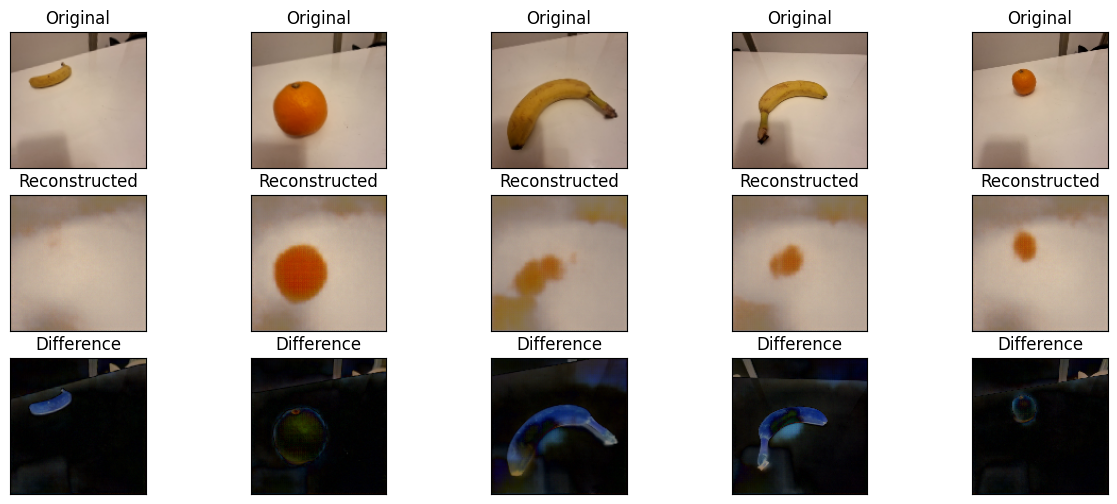

In [8]:
# Ensure this follows after the autoencoder has been trained and predictions have been generated  
  
# Plot original, reconstruction, and difference on test set  
n = 5  # How many digits we will display  
plt.figure(figsize=(15, 6))  # Adjusted size for better visualization  
for i in range(n):  
    # Display original  
    ax = plt.subplot(3, n, i + 1)  
    plt.imshow(x_test[i], cmap='gray')  # Set the correct color map or remove for RGB  
    plt.title("Original")  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
  
    # Display reconstruction     
    ax = plt.subplot(3, n, i + 1 + n)  
    plt.imshow(x_test_pred[i], cmap='gray')  # Set the correct color map or remove for RGB  
    plt.title("Reconstructed")  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
  
    # Display difference    
    diff = np.abs(x_test[i] - x_test_pred[i])  
    ax = plt.subplot(3, n, i + 1 + 2*n)  
    plt.imshow(diff, cmap='gray')  # Set the correct color map or use 'viridis' for RGB  
    plt.title("Difference")  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
  
plt.show()  

Optimal threshold based on F1 score: 0.0440035432571926


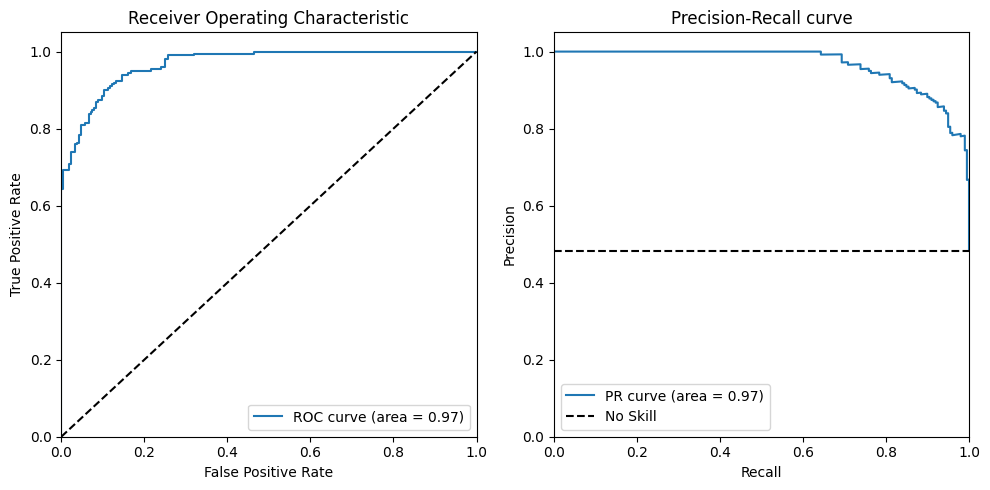

Confusion Matrix with optimal threshold:
[[182  31]
 [ 13 186]]

Classification Report with optimal threshold:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       213
           1       0.86      0.93      0.89       199

    accuracy                           0.89       412
   macro avg       0.90      0.89      0.89       412
weighted avg       0.90      0.89      0.89       412



In [9]:
import numpy as np  
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import auc, roc_curve, precision_recall_curve, f1_score  
import matplotlib.pyplot as plt  
# Label anomalies as 1  
y_true = (y_test == 1).astype(int)  
  
# Calculate the ROC curve and AUC  
false_positive_rate, true_positive_rate, thresholds_roc = roc_curve(y_true, reconstruction_error)  
roc_auc = auc(false_positive_rate, true_positive_rate)  
  
# Calculate the precision-recall curve and AUC  
precision, recall, thresholds_pr = precision_recall_curve(y_true, reconstruction_error)  
pr_auc = auc(recall, precision)  
  
# Calculate the F1 score for each threshold  
f1_scores = 2*recall*precision / (recall + precision)  
best_threshold_index = np.argmax(f1_scores)  # Index of the best F1 score  
optimal_threshold = thresholds_pr[best_threshold_index]  
  
print(f"Optimal threshold based on F1 score: {optimal_threshold}")  
  
# Plotting ROC curve  
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)  
plt.plot(false_positive_rate, true_positive_rate, label=f'ROC curve (area = {roc_auc:.2f})')  
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver Operating Characteristic')  
plt.legend(loc="lower right")  
  
# Plotting Precision-Recall curve  
plt.subplot(1, 2, 2)  
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')  
plt.plot([0, 1], [np.sum(y_true)/len(y_true), np.sum(y_true)/len(y_true)], 'k--', label='No Skill')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('Recall')  
plt.ylabel('Precision')  
plt.title('Precision-Recall curve')  
plt.legend(loc="lower left")  
  
plt.tight_layout()  
plt.show()  
  
# Using the optimal threshold determined above to classify anomalies  
y_pred_optimal = (reconstruction_error > optimal_threshold).astype(int)  
  
# Print stats with the optimal threshold  
print("Confusion Matrix with optimal threshold:")  
print(confusion_matrix(y_true, y_pred_optimal))  
print("\nClassification Report with optimal threshold:")  
print(classification_report(y_true, y_pred_optimal))  

1/1 [==============================] - 0s 21ms/step
Status: Anomaly, Reconstruction Error: 0.07542719308281177


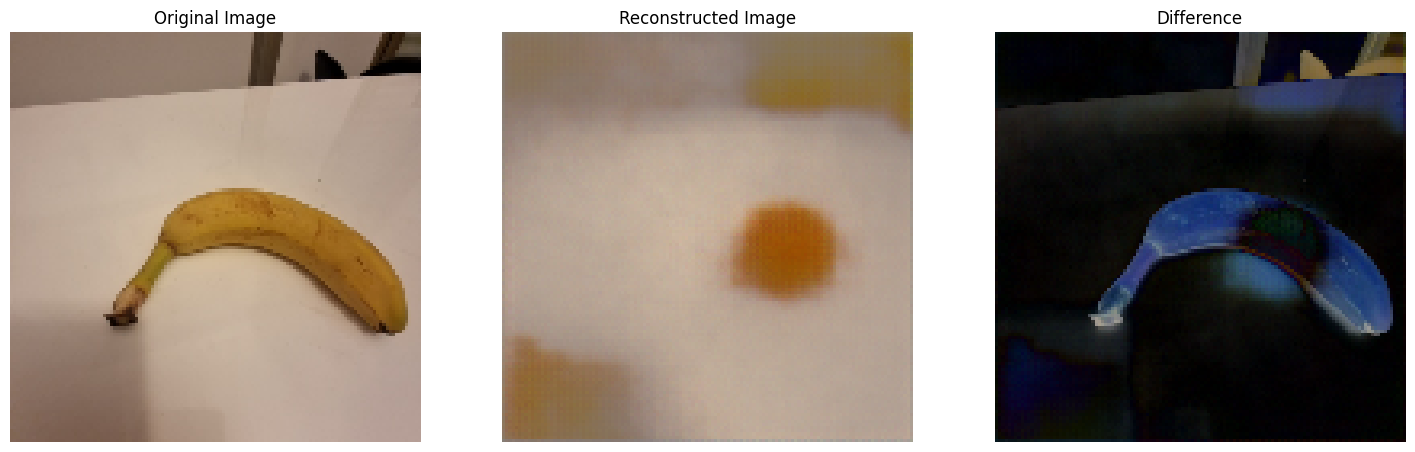

1/1 [==============================] - 0s 19ms/step
Status: Good, Reconstruction Error: 0.04074147884948887


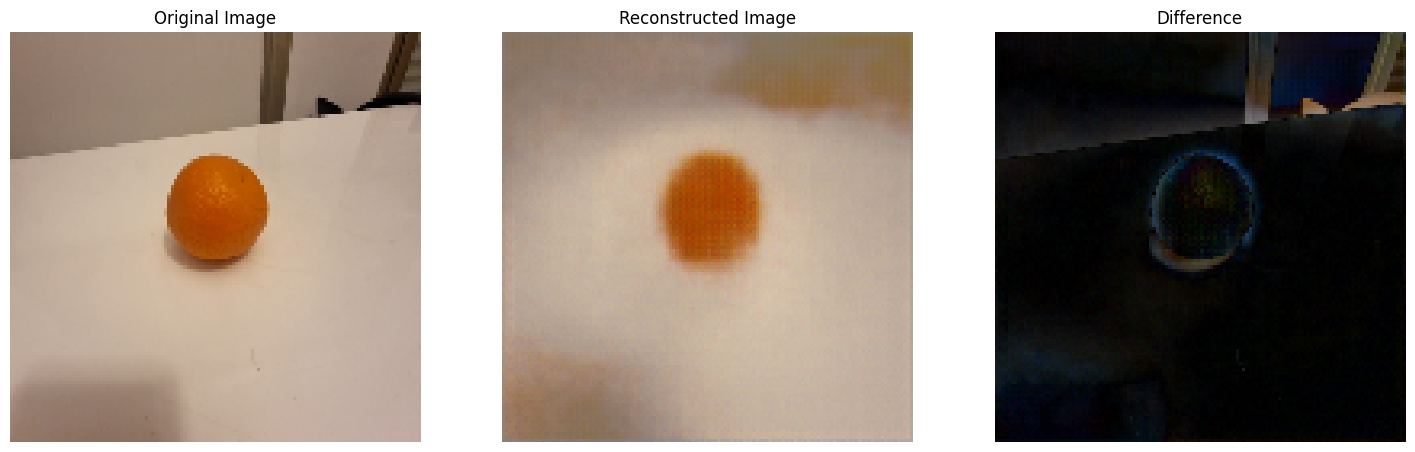

In [10]:
def preprocess_image(image_path):  
    """  
    Load an image, resize it, and normalize it.  
    """  
    image = mpimg.imread(image_path)  
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) if image.shape[-1] == 4 else image  # Convert RGBA to RGB if necessary.  
    image = cv2.resize(image, (img_size, img_size))  # Resize the image.  
    image = image / 255.0  # Normalize the image.  
    return np.array([image])  # Add batch dimension.
  
def predict_image_status(model, image_path, threshold=0.07):  
    """  
    Predict whether an image is 'good' or an 'anomaly' based on the reconstruction error.  
    """  
    preprocessed_image = preprocess_image(image_path)
    reconstructed_image = model.predict(preprocessed_image)  
    reconstruction_error = np.mean(np.abs(preprocessed_image - reconstructed_image))  
      
    is_anomaly = reconstruction_error > threshold  
    status = 'Anomaly' if is_anomaly else 'Good'  
    
    print(f"Status: {status}, Reconstruction Error: {reconstruction_error}")  
    # Invoke the display function  
    # Removing the batch dimension for display  
    original_np = np.squeeze(preprocessed_image, axis=0)  
    reconstructed_np = np.squeeze(reconstructed_image, axis=0)  
    display_images(original_np, reconstructed_np)  
    
def display_images(original, reconstructed):  
    """Display original, reconstructed images, and their difference."""  
    plt.figure(figsize=(18, 6))  
      
    # Original   
    plt.subplot(1, 3, 1)  
    plt.title('Original Image')  
    plt.imshow(original)  
    plt.axis('off')  
      
    # Reconstructed  
    plt.subplot(1, 3, 2)  
    plt.title('Reconstructed Image')  
    plt.imshow(reconstructed)  
    plt.axis('off')  
      
    # Difference  
    plt.subplot(1, 3, 3)  
    plt.title('Difference')  
    difference = np.abs(original - reconstructed)  
    plt.imshow(difference, cmap='gray')  
    plt.axis('off')  
      
    plt.show()
    
# Example usage:  
predict_image_status(autoencoder, "test/banana.4piv5bho.ingestion-d59dc547b-j6mhk.jpg", threshold=optimal_threshold)  
predict_image_status(autoencoder, "test/orange.4piv9lmk.ingestion-d59dc547b-94nn2.jpg", threshold=optimal_threshold)  
  

In [11]:
model_save_path = "output/saved_model"  
tf.saved_model.save(autoencoder, model_save_path)

autoencoder.save('output/autoencoder_model.h5')  

INFO:tensorflow:Assets written to: output/saved_model/assets


INFO:tensorflow:Assets written to: output/saved_model/assets
/Users/m/dev/6be709c0/oc-ai-engineer/OC/P9/v1-cnn-encoder/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Load the saved model  
saved_model = tf.keras.models.load_model('output/autoencoder_model.h5')  
  
# Convert the model to TensorFlow Lite format  
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)  
tflite_model = converter.convert()  
  
# Save the converted model to a .tflite file  
with open('output/autoencoder_model.tflite', 'wb') as f_out:  
    f_out.write(tflite_model)  

INFO:tensorflow:Assets written to: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp4j6lav_g/assets


INFO:tensorflow:Assets written to: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp4j6lav_g/assets
2024-04-10 17:49:54.996517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-10 17:49:54.996531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-10 17:49:54.997081: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp4j6lav_g
2024-04-10 17:49:54.998655: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-10 17:49:54.998662: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp4j6lav_g
2024-04-10 17:49:55.001999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-10 17:49:55.003570: I tensorflow/cc/saved_model/load